In [17]:
val_files = [{"image": ["Data_BRATS/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz", 
                        "Data_BRATS/BraTS2021_00000/BraTS2021_00000_t1.nii.gz", 
                        "Data_BRATS/BraTS2021_00000/BraTS2021_00000_t2.nii.gz", 
                        "Data_BRATS/BraTS2021_00000/BraTS2021_00000_flair.nii.gz"], 
            "label": "Data_BRATS/BraTS2021_00000/BraTS2021_00000_seg.nii.gz"}]

In [18]:
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    LoadImaged,
    ConvertToMultiChannelBasedOnBratsClassesd,
    RandSpatialCropd,
    RandFlipd,
    MapTransform,
    NormalizeIntensityd, 
    RandScaleIntensityd,
    RandShiftIntensityd,
    ToTensord,
    CenterSpatialCropd,
    ScaleIntensityRanged
)
from monai.data import DataLoader, Dataset
import numpy as np
import json
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """
 
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(np.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 1, d[key] == 4), d[key] == 2
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d
val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            ConvertToMultiChannelBasedOnBratsClassesd(
                keys = ['label']),
            CenterSpatialCropd(keys=["image", "label"],
                            roi_size = [128,128,128], 
                            ),
            # ScaleIntensityRanged(keys=["image", "label"], a_max=1, a_min=0),
            # NormalizeIntensityd(keys = "image",
            #                    nonzero = True,
            #                    channel_wise = True),
        ]
    )
val_ds = Dataset(data=val_files, transform=val_transform)


In [19]:
val_ds[0]['image'].shape

(4, 128, 128, 128)

2535.0 0.0


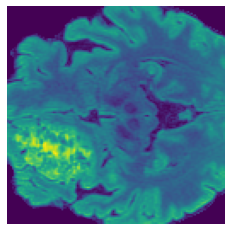

In [25]:
import matplotlib.pyplot as plt 
import cv2
img = val_ds[0]['image'][3, :, :, 50]
print(img.max(), img.min())
plt.imshow(img)
plt.axis('off')
plt.savefig('foo.png', bbox_inches='tight', pad_inches=0)



1 244


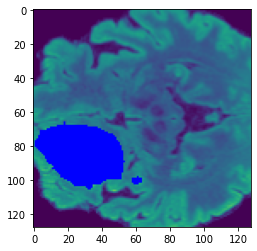

In [54]:
import cv2 
img = cv2.imread('foo.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
print(img.min(), img.max())

label = val_ds[0]['label'][0, :, :, 50]
img[label  == 1.0] = [0, 0 , 255]
plt.imshow(img)
plt.show()

In [40]:
print(img.shape, label.shape)

(217, 217, 3) (128, 128)
